In [1]:
import numpy as np
import pandas as pd 
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin

def load_data(in_path, name):
    df = pd.read_csv(in_path)
    return df

def load_datasets(DATA_DIR, ds_names):
    datasets = {}
    for ds_name in ds_names:
        datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)
    return datasets
    
def pct(x):
    return round(100*x,3)

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score

def show_scores(y, y_pred, percentages=False):
    conf_mx = confusion_matrix(y, y_pred)
    if percentages:
        conf_mx = 100*conf_mx/y.shape[0]
    print('scores\n')
    print('precision', precision_score(y, y_pred))
    print('recall   ', recall_score(y, y_pred))
    print('f1       ', f1_score(y, y_pred))
    print('accuracy ', np.sum(y == y_pred)/y.shape[0])

    ax= plt.subplot()
    sns.heatmap(conf_mx, annot=True, fmt='3.1f')
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    
from IPython.display import display, HTML, Javascript

js_getResults = """<script>
alert("Hello! I am an alert box!");
</script>"""

def alert():
    display(HTML(js_getResults))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [6]:
DATA_DIR = "../data"
# ds_names = ("application_train", "application_test", "bureau","bureau_balance","credit_card_balance","installments_payments",
#             "previous_application","POS_CASH_balance")
ds_names = ("application_train", "application_test")

datasets = load_datasets(DATA_DIR, ds_names)

In [7]:
app = datasets['application_train']

- amt_credit - right skewed - not much difference between 0 and 1
- AMT_INCOME_TOTAL - right skewed - median of 1 slightly lower than 0
- AMT_ANNUITY - right skewed
- AMT_GOODS_PRICE - right skewed
- REGION_POPULATION_RELATIVE - outliers on the right
- DAYS_REGISTRATION - left skewed (reflet and sqrt looks normal, but other days are log transformed)
- DAYS_ID_PUBLISH - looks okay
- OWN_CAR_AGE - right skewed - log transform
- DAYS_LAST_PHONE_CHANGE - left skewed (reflect and sqrt looks centered)

adding info about building increased train scores and reduced cv and test scores 

### Transformations

In [107]:
# one unusual row of id: 272071 where SOCIAL CIRCLE (4 features) values are extremely high
#datasets['application_train'].drop(np.where(datasets['application_train']['SK_ID_CURR']==272071)[0][0], axis=0, inplace=True)

In [8]:
def corr_lr(X, y, score=roc_auc_score):
    lr = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), LogisticRegression(class_weight='balanced'))
    lr.fit(X, y)
    return score(y, lr.predict(X))

def corr_lr_xsfrm(df, attr, f, score=roc_auc_score):
    X = df[[attr]]
    y = df['TARGET']   
    print('score:before', np.round(corr_lr(X, y, score), 5))
    
    X = f(X)  
    print('score:after', np.round(corr_lr(X, y, score), 5))

In [9]:
mask = app['CODE_GENDER'] == 'M'
x,y = app[mask]['TARGET'].value_counts(), app[~mask]['TARGET'].value_counts()

100*np.round((x[1]/np.sum(x), y[1]/np.sum(y)), 4)

array([10.14,  7.  ])

### Pipeline

In [10]:
def transform_days(X):
    mask = X > 0
    X[mask] = np.NaN
    # return np.log1p(-1*X)
    return -X

def preprocessing_transformations(df, inplace=False):
    # pure state-less transformations 
    if inplace:
        df_new = df
    else:
        df_new = df.copy()
    
    
    right_skewed = ['AMT_ANNUITY']
    left_skewed = []
    days = ['DAYS_EMPLOYED']
    
    transform_left_skewed = lambda X: np.log(1+np.max(X)-X)
    
    df_new[right_skewed] = np.log1p(df[right_skewed])
    df_new[left_skewed] = transform_left_skewed(df[left_skewed])
    df_new[days] = transform_days(df[days])
    
    # others
    df_new['OWN_CAR_AGE'] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(df[['OWN_CAR_AGE']]).ravel()
    df['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
    df['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)
    df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
    
    return df_new
    
def add_new_features(df, inplace=False):
    if inplace:
        X = df
    else:
        X = df.copy()
    X['annuity_income_percentage'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
    X['car_to_birth_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_BIRTH']
    X['car_to_employ_ratio'] = X['OWN_CAR_AGE'] / (1+X['DAYS_EMPLOYED'])
    X['children_ratio'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']
    X['credit_to_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
    X['credit_to_goods_ratio'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
    X['credit_to_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
    X['days_employed_percentage'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
    X['income_credit_percentage'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
    X['income_per_child'] = X['AMT_INCOME_TOTAL'] / (1 + X['CNT_CHILDREN'])
    X['income_per_person'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
    X['payment_rate'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
    X['phone_to_birth_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_BIRTH']
    X['phone_to_employ_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / (1+X['DAYS_EMPLOYED'])
    X['external_source_mean'] = X[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    X['cnt_non_child'] = X['CNT_FAM_MEMBERS'] - X['CNT_CHILDREN']
    X['child_to_non_child_ratio'] = X['CNT_CHILDREN'] / X['cnt_non_child']
    X['income_per_non_child'] = X['AMT_INCOME_TOTAL'] / X['cnt_non_child']
    X['credit_per_person'] = X['AMT_CREDIT'] / X['CNT_FAM_MEMBERS']
    X['credit_per_child'] = X['AMT_CREDIT'] / (1 + X['CNT_CHILDREN'])
    X['credit_per_non_child'] = X['AMT_CREDIT'] / X['cnt_non_child']
    
    return X

In [11]:
# Identify the numeric features we wish to consider. 
num_attribs = ['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 
               'DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3', 'DAYS_ID_PUBLISH',
               'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'OWN_CAR_AGE', 'OBS_30_CNT_SOCIAL_CIRCLE', 
               'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
               'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
               'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
               'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 
               'HOUR_APPR_PROCESS_START']
new_features = ['annuity_income_percentage', 'car_to_birth_ratio', 'car_to_employ_ratio', 'children_ratio', 
                'credit_to_annuity_ratio', 'credit_to_goods_ratio', 'credit_to_income_ratio', 'days_employed_percentage', 
                'income_credit_percentage', 'income_per_child', 'income_per_person', 'payment_rate', 'phone_to_birth_ratio', 
                'phone_to_employ_ratio', 'external_source_mean', 'cnt_non_child', 'child_to_non_child_ratio', 
               'income_per_non_child', 'credit_per_person', 'credit_per_child', 'credit_per_non_child']
num_attribs_total = num_attribs + new_features

# num_ct = ColumnTransformer([
#     ('right-skewed-log-transform', FunctionTransformer(lambda X: np.log1p(X)), ['AMT_ANNUITY']),
#     ('DAYS_EMPLOYED', DaysEmployedXFMR(), ['DAYS_EMPLOYED']), # remove pos values, flip on origin, and log transform
#     # ('EXT_SOURCE_2', FunctionTransformer(lambda X: np.log1p(np.max(X)-X)), ['EXT_SOURCE_2']), # left skewed, reflect and log transform
#     # ('bar', FunctionTransformer(lambda X: np.log(1+np.max(X)-X)), ['DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE']),
#     ('missing_0', SimpleImputer(strategy='constant', fill_value=0), ['OWN_CAR_AGE'])
# ], remainder='passthrough')

num_pipeline = Pipeline([
        ('new_features', FunctionTransformer(add_new_features)),
        ('selector', DataFrameSelector(num_attribs_total)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

# cat_attribs = ['CODE_GENDER']
cat_attribs = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
               'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE','WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
               'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 
               'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
               'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 
               'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 
               'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
               'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
               'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

data_prep_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

selected_attribs = num_attribs_total + cat_attribs

In [17]:
y = datasets['application_train']['TARGET']
X = preprocessing_transformations(datasets['application_train'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_kaggle_test = datasets['application_test']

In [42]:
%%time
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("linear", LogisticRegression(penalty='l1', C=0.005, class_weight='balanced', solver='saga'))
    ])
model = full_pipeline_with_predictor.fit(X_train, y_train)

CPU times: user 47.2 s, sys: 902 ms, total: 48.1 s
Wall time: 48.5 s


#### Missing Values

In [19]:
X_sel = add_new_features(X)[selected_attribs]
percent = (X_sel.isnull().sum()/X_sel.isnull().count()*100).sort_values(ascending = False).round(2)
percent.head(20)

EXT_SOURCE_1                  56.38
WALLSMATERIAL_MODE            50.84
HOUSETYPE_MODE                50.18
EMERGENCYSTATE_MODE           47.40
OCCUPATION_TYPE               31.35
EXT_SOURCE_3                  19.83
phone_to_employ_ratio         18.01
days_employed_percentage      18.01
ORGANIZATION_TYPE             18.01
DAYS_EMPLOYED                 18.01
car_to_employ_ratio           18.01
AMT_REQ_CREDIT_BUREAU_HOUR    13.50
AMT_REQ_CREDIT_BUREAU_YEAR    13.50
AMT_REQ_CREDIT_BUREAU_QRT     13.50
AMT_REQ_CREDIT_BUREAU_MON     13.50
AMT_REQ_CREDIT_BUREAU_WEEK    13.50
AMT_REQ_CREDIT_BUREAU_DAY     13.50
NAME_TYPE_SUITE                0.42
DEF_60_CNT_SOCIAL_CIRCLE       0.33
OBS_60_CNT_SOCIAL_CIRCLE       0.33
dtype: float64

In [43]:
cat_features = [f'{base}_{c}'for base, ohe_c in zip(cat_attribs, cat_pipeline.named_steps['ohe'].categories_) for c in ohe_c ]
features = num_attribs_total + cat_features
len(features), len(num_attribs_total), len(cat_features)

(255, 50, 205)

### Evaluate

In [44]:
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_train, y_train_pred_proba), roc_auc_score(y_test, y_test_pred_proba)

(0.7476472133471364, 0.7492941873314127)

In [407]:
#del expLog

In [21]:
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_train_pred = y_train_pred_proba > 0.5
y_test_pred = y_test_pred_proba > 0.5
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', verbose=1)


try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["exp_name", 
                                   "Train AUC", 
                                   "5-fold Valid AUC",
                                   "5-fold Valid AUC std",
                                   "Test  AUC"
                                  ])

exp_name = f"Baseline_{len(selected_attribs)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [roc_auc_score(y_train, y_train_pred_proba),
                scores.mean(),
                scores.std(),
                roc_auc_score(y_test, y_test_pred_proba)],
    4)) 
expLog

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.5s finished


,exp_name,Train AUC,5-fold Valid AUC,5-fold Valid AUC std,Test AUC
0,Baseline_97_features,0.7511,0.7486,0.005,0.7517


In [22]:
alert()

In [23]:
print(classification_report(y_train, y_train_pred_proba>0.5))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80    226148
           1       0.16      0.68      0.26     19860

    accuracy                           0.69    246008
   macro avg       0.56      0.69      0.53    246008
weighted avg       0.90      0.69      0.76    246008



In [24]:
print(classification_report(y_test, y_test_pred_proba>0.5))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503



#### Confusion Matrix

scores

precision 0.16260905092648226
recall    0.6813695871097684
f1        0.2625584508818565
accuracy  0.6910100484537088


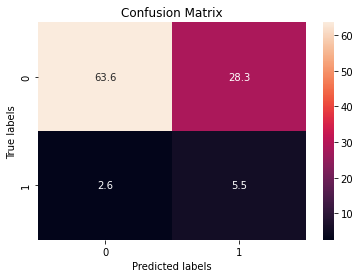

In [25]:
show_scores(y_train, y_train_pred, percentages=True)

scores

precision 0.16167059616032334
recall    0.676737160120846
f1        0.26099114494329656
accuracy  0.6906167178836805


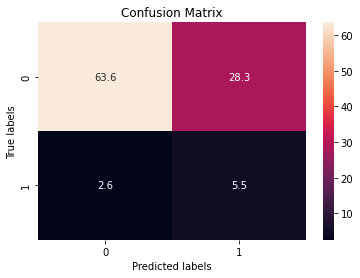

In [26]:
show_scores(y_test, y_test_pred, percentages=True)

### Importances

In [60]:
lm = full_pipeline_with_predictor['linear']
imp = pd.DataFrame(lm.coef_.T/np.sum(np.abs(lm.coef_)), index=features, columns=['Imp'])\
.abs()\
.sort_values(by='Imp', ascending=False)

In [82]:
elim_f = sorted(imp.index[imp['Imp'] == 0].to_list())

In [84]:
# set([f if f in num_attribs_total else '_'.join(f.split('_')[:-1]) for f in elim_f])
set([f for f in elim_f if f in num_attribs_total])

{'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT',
 'car_to_birth_ratio',
 'car_to_employ_ratio',
 'credit_per_child',
 'credit_per_non_child',
 'income_per_non_child'}

In [86]:
set(['_'.join(f.split('_')[:-1]) for f in elim_f if f not in num_attribs_total])

{'CODE_GENDER',
 'EMERGENCYSTATE_MODE',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_EMAIL',
 'FLAG_EMP_PHONE',
 'FLAG_MOBIL',
 'FLAG_OWN_REALTY',
 'FLAG_PHONE',
 'HOUSETYPE_MODE',
 'LIVE_CITY_NOT_WORK_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'NAME_TYPE_SUITE',
 'NAME_TYPE_SUITE_Other',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'REG_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'WALLSMATERIAL_MODE',
 'WEEKDAY_APPR_PROCESS_START'}